**Make sure you run this at the begining**

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# Append template path to sys path
sys.path.append(os.getcwd() + "/template") 

In [2]:
from utils.load_data import load_data
from utils.load_data import log
from utils.visualize_tsp import plotTSP
from utils.tsp import TSP
from utils.tsp import TSP_Bench
from utils.tsp import TSP_Bench_ALL

# Workshop Starts Here

<img src="images/tsp.jpg" alt="TSP" style="width: 900px;"/>

<img src="images/solutions.png" alt="solutions" style="width: 900px;"/>

# Get familiar with your dataset

There are problems at different levels. **3 simple, 2 medium, 1 hard**.

In [3]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [4]:
ulysses16 = np.array(load_data("./template/data/simple/ulysses16.tsp"))

In [5]:
ulysses16[:]

array([[38.24, 20.42],
       [39.57, 26.15],
       [40.56, 25.32],
       [36.26, 23.12],
       [33.48, 10.54],
       [37.56, 12.19],
       [38.42, 13.11],
       [37.52, 20.44],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [36.08, -5.21],
       [38.47, 15.13],
       [38.15, 15.35],
       [37.51, 15.17],
       [35.49, 14.32],
       [39.36, 19.56]])

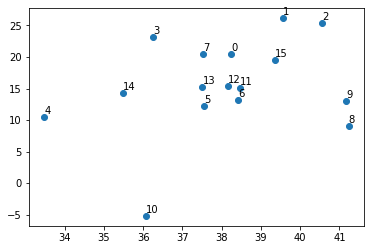

In [6]:
plt.scatter(ulysses16[:, 0], ulysses16[:, 1])
for i in range(0, 16):
    plt.annotate(i, (ulysses16[i, 0], ulysses16[i, 1]+0.5))

## Naive Solution: In Order

In [7]:
simple_sequence = list(range(0, 16))
print(simple_sequence)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


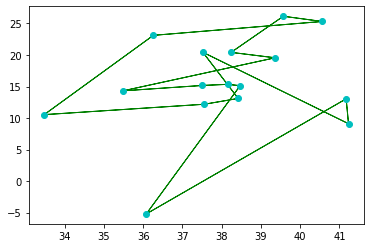

In [8]:
plotTSP([simple_sequence], ulysses16, num_iters=1)

## Naive Solution: Random Permutation

In [9]:
random_permutation = np.random.permutation(16).tolist()
print(random_permutation)

[4, 15, 11, 6, 9, 13, 5, 3, 2, 12, 14, 8, 10, 1, 7, 0]


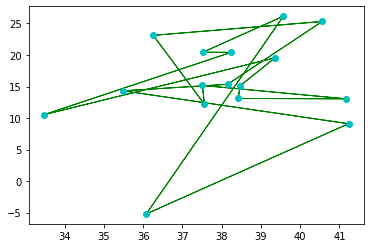

In [10]:
plotTSP([random_permutation], ulysses16, num_iters=1)

## Best Solution

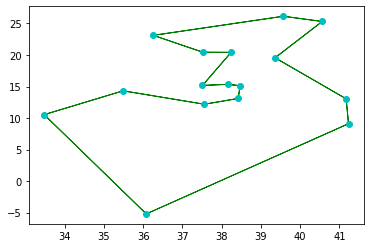

In [11]:
best_ulysses16 = [0, 13, 12, 11, 6, 5, 14, 4, 10, 8, 9, 15, 2, 1, 3, 7]
plotTSP([best_ulysses16], ulysses16, num_iters=1)

## Calculate Fitness (Sum of all Distances)

In [12]:
def dist(node_0, node_1, coords):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = coords[node_0], coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

In [13]:
print("Coordinate of City 0:", ulysses16[0])

Coordinate of City 0: [38.24 20.42]


In [14]:
print("Coordinate of City 1:", ulysses16[1])

Coordinate of City 1: [39.57 26.15]


In [15]:
print("Distance Between", dist(0, 1, ulysses16))

Distance Between 5.882329470541408


In [16]:
def fitness(solution, coords):
    N = len(coords)
    cur_fit = 0
    for i in range(len(solution)):
        cur_fit += dist(solution[i % N], solution[(i + 1) % N], coords)
    return cur_fit

In [17]:
print ("Order Fitness:\t", fitness(simple_sequence, ulysses16))
print ("Random Fitness:\t", fitness(random_permutation, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Order Fitness:	 104.42225210207233
Random Fitness:	 128.48861505039284
Best Fitness:	 74.10873595815309


## Naive Random Model

In [18]:
import math
import random
from model.base_model import Model

class MyRandomModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        random_solutions = []
        for i in range(0, max_it):
            solution = np.random.permutation(self.N).tolist()
            random_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = random_solutions[self.fitness_list.index(min(self.fitness_list))]
        return self.best_solution, self.fitness_list

In [19]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [20]:
model = MyRandomModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, max_it=100)

[*] [Node] 16, [Best] 103.2048389639759
[*] Running for: 0.00 seconds



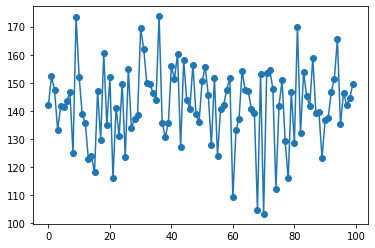

In [21]:
plt.plot(fitness_list, 'o-')

## Uniform Cost Search

In [22]:
import math
import random
from model.base_model import Model

class MyUCSModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def getMST(self, node):
        MST = []
        distances = []
        for i in range(0, self.N):
            if i != node:
                MST.append(i)
                distances.append(self.dist(node, i))
        return [x for _,x in sorted(zip(distances, MST))]

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        UCS_solutions = []
        UCS_losses = []
    
        for i in range(0, self.N):
            solution = [i]
            UCS_solutions.append(solution)
            UCS_losses.append(math.inf)
    
        MSTs = []
        for i in range(0, self.N):
            MSTs.append([-1] * self.N)

        # Breadth First: Set each city as starting point, then go to next city simultaneously
        min_loss = math.inf
        while(len(UCS_solutions[ UCS_losses.index(min(UCS_losses)) ]) != self.N):
            unvisited_list = list(range(0, self.N))
            min_loss = min(UCS_losses)
            # For each search path
            for i in range(0, self.N):
                if UCS_losses[i] == min_loss:
                    cur_city = UCS_solutions[i][-1]
                    unvisited_list = list( set(range(0, self.N)) - set(UCS_solutions[i]) )
                    if MSTs[cur_city][0] == -1:
                        MST = self.getMST(cur_city)
                        MSTs[cur_city] = MST

                    for j in MSTs[cur_city]:
                        if(j in unvisited_list):
                            UCS_solutions[i].append(j)

                            N = len(UCS_solutions[i])
                            cur_fit = 0
                            for k in range(len(UCS_solutions[i])):
                                coord_0, coord_1 = self.coords[UCS_solutions[i][k % N]], self.coords[UCS_solutions[i][(k + 1) % N]]
                                cur_fit += math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)
                            UCS_losses[i] = cur_fit
#                             if(UCS_losses[i] < min_loss):
#                                 min_loss = UCS_losses[i]
                            break
        self.best_solution = UCS_solutions[ UCS_losses.index(min(UCS_losses)) ]
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

In [23]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [24]:
model = MyUCSModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds



## A star

Heuristic

In [25]:
import math
import random
from model.base_model import Model

class MyASModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def getMST(self, node):
        MST = []
        distances = []
        for i in range(0, self.N):
            if i != node:
                MST.append(i)
                distances.append(self.dist(node, i))
        return [x for _,x in sorted(zip(distances, MST))]

    def fit(self, max_it):
        """
        Put your iteration process here.
        """

        MST_solutions = []
    
        for i in range(0, self.N):
            solution = [i]
            MST_solutions.append(solution)
    
        # Breadth First: Set each city as starting point, then go to next city simultaneously
        for step in range(0, self.N - 1):
#             print("[step]", step)
            unvisited_list = list(range(0, self.N))
            # For each search path
            for i in range(0, self.N):
                cur_city = MST_solutions[i][-1]
                unvisited_list = list( set(range(0, self.N)) - set(MST_solutions[i]) )
                closest_neighbour = -1
                min_f = math.inf
                    
                for j in unvisited_list:
                    g = self.dist(cur_city, j)
                    sub_unvisited_list = unvisited_list.copy()
                    sub_unvisited_list.remove(j)

                    sub_cur_city = self.getMST(j)[0]
                    h = 0
                    while len(sub_unvisited_list) > 0:
                        if(len(unvisited_list) == 2):
                            break
                        else:
                            for k in self.getMST(sub_cur_city):
                                if k in sub_unvisited_list:
                                    h = h + self.dist(sub_cur_city, k)
                                    sub_cur_city = k
                                    sub_unvisited_list.remove(k)
                                    break
                    # Get f(x) = g(x) + h(x)

                    f = g + h
                    if(f < min_f):
                        closest_neighbour = j
                        min_f = f
                MST_solutions[i].append(closest_neighbour)

        for i in range(0, self.N):
            self.fitness_list.append(self.fitness(MST_solutions[i]))
 
        self.best_solution = MST_solutions[ self.fitness_list.index(min(self.fitness_list)) ]

        return self.best_solution, self.fitness_list

In [26]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [27]:
model = MyASModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 77.02641196679659
[*] Running for: 0.24 seconds



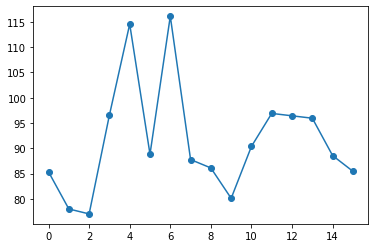

In [28]:
plt.plot(fitness_list, 'o-')

## Hill Climbing

Heuristic Iteration

In [29]:
import math
import random
import numpy as np
from model.base_model import Model

class MyHillClimbModel(Model):

    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def random_tour(self):
        return np.random.permutation(self.N).tolist()

    def all_pairs(self, size, shuffle=random.shuffle):
        r1 = list(range(size))
        r2 = list(range(size))
        if shuffle:
            shuffle(r1)
            shuffle(r2)
        for i in r1:
            for j in r2:
                yield (i,j)

    def move_operator(self, tour):
        '''generator to return all possible variations
          where the section between two cities are swapped'''
        for i,j in self.all_pairs(len(tour)):
            if i != j:
                copy=tour[:]
                if i < j:
                    copy[i:j+1]=reversed(tour[i:j+1])
                else:
                    copy[i+1:]=reversed(tour[:j])
                    copy[:j]=reversed(tour[i+1:])
                if copy != tour: # no point returning the same tour
                    yield copy

    def fit(self, max_it=100):
        """
        Put your iteration process here.
        """

        self.best_solution = self.random_tour()
        best_score = -self.fitness(self.best_solution)

        num_evaluations = 0

        while num_evaluations < max_it:
            # examine moves around our current position
            move_made = False
            for next_solution in self.move_operator(self.best_solution):
                if num_evaluations >= max_it:
                    print("Max iteration reached:", max_it)
                    break

                # see if this move is better than the current
                next_score = -self.fitness(next_solution)
                num_evaluations += 1
                if next_score > best_score:
                    self.best_solution = next_solution
                    self.fitness_list.append(self.fitness(self.best_solution))
                    best_score=next_score
                    move_made=True
                    break # depth first search

            if not move_made:
                break # we couldn't find a better move (must be at a local maximum)

        return self.best_solution, self.fitness_list

In [30]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [31]:
model = MyHillClimbModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[*] [Node] 16, [Best] 75.20004295930718
[*] Running for: 0.01 seconds



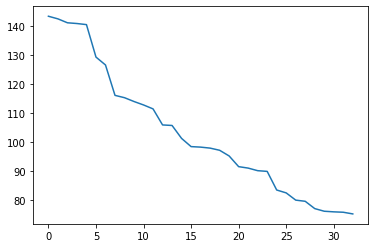

In [32]:
plt.plot(fitness_list)

## Your Smart Model

In [33]:
import math
import random
from model.base_model import Model

class MyModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)
        self.log("Nothing to initialize in your model now")

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        self.best_solution = np.random.permutation(self.N).tolist()
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

## Test your Model

In [34]:
tsp_problem = './template/data/simple/ulysses16.tsp'

In [35]:
model = MyModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[MyModel] Nothing to initialize in your model now
[*] [Node] 16, [Best] 148.18952217033015
[*] Running for: 0.00 seconds



## Test All Dataset

In [36]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [37]:
tsp_path = './template/data'

In [38]:
def plot_results(best_solutions, times, title):
    fig = plt.figure()
    nodes = [len(s) for s in best_solutions]
    data = np.array([[node, time] for node, time in sorted(zip(nodes, times))])
    plt.plot(data[:, 0], data[:, 1], 'o-')
    fig.suptitle(title, fontsize=20)

In [39]:
model = MyRandomModel()

print("Random Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Random Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 726650.2719896487
[*] Running for: 0.38 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 31046.898980759102
[*] Running for: 0.22 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] [Node] 1000, [Best] 531016891.20882976
[*] Running for: 1.06 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 121918.36235964627
[*] Running for: 0.07 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 96.82217370013487
[*] Running for: 0.02 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 3084.202093710709
[*] Running for: 0.08 seconds



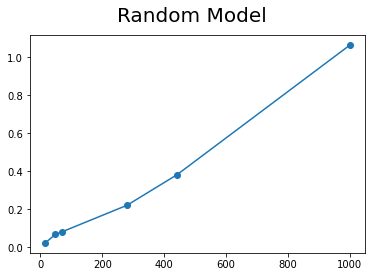

In [40]:
plot_results(best_solutions, times, "Random Model")

In [41]:
model = MyUCSModel()

print("Uniform Cost Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Uniform Cost Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 58952.967129705365
[*] Running for: 47.11 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 3088.6042241002488
[*] Running for: 9.48 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 60.04 seconds

[*] ./template/data/simple/att48.tsp
[*] [Node] 48, [Best] 39236.884898455035
[*] Running for: 0.08 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.12688501241215
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
[*] [Node] 70, [Best] 761.6890898866324
[*] Running for: 0.17 seconds



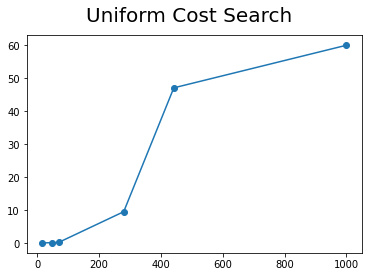

In [42]:
plot_results(best_solutions, times, "Uniform Cost Search")

In [43]:
model = MyASModel()

print("A Star Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

A Star Search
[*] ./template/data/medium/pcb442.tsp
[*] Timeout -3
[*] Running for: 60.01 seconds

[*] ./template/data/medium/a280.tsp
[*] Timeout -3
[*] Running for: 60.01 seconds

[*] ./template/data/hard/dsj1000.tsp
[*] Timeout -3
[*] Running for: 60.02 seconds

[*] ./template/data/simple/att48.tsp
[*] Timeout -3
[*] Running for: 60.00 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 77.02641196679659
[*] Running for: 0.27 seconds

[*] ./template/data/simple/st70.tsp
[*] Timeout -3
[*] Running for: 60.00 seconds



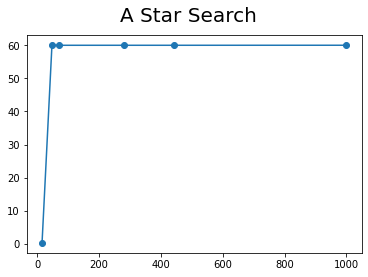

In [44]:
plot_results(best_solutions, times, "A Star Search")

In [45]:
model = MyHillClimbModel()

print("Hill-Climbing Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Hill-Climbing Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 534598.7236016603
[*] Running for: 0.54 seconds

[*] ./template/data/medium/a280.tsp
Max iteration reached: 1000
[*] [Node] 280, [Best] 20166.72717957085
[*] Running for: 0.27 seconds

[*] ./template/data/hard/dsj1000.tsp
Max iteration reached: 1000
[*] [Node] 1000, [Best] 447129851.29925376
[*] Running for: 1.22 seconds

[*] ./template/data/simple/att48.tsp
Max iteration reached: 1000
[*] [Node] 48, [Best] 48649.76285824257
[*] Running for: 0.04 seconds

[*] ./template/data/simple/ulysses16.tsp
[*] [Node] 16, [Best] 73.99982631274877
[*] Running for: 0.01 seconds

[*] ./template/data/simple/st70.tsp
Max iteration reached: 1000
[*] [Node] 70, [Best] 1628.8466328473826
[*] Running for: 0.06 seconds



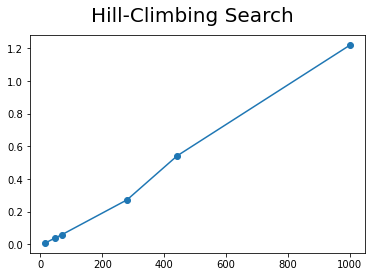

In [46]:
plot_results(best_solutions, times, "Hill-Climbing Search")

# Conclusions

In [47]:
# Simple
# ulysses16:  77.12 (UCS-BFS),     77.02 (A-Star)
# att48:      39236 (UCS-BFS),     47853 (A-Star)
# st70:         761 (UCS-BFS),  time-out (A-Star)

# Medium
# a280:       3088 (UCS-BFS),   time-out (A-Star)
# pcb442:    58952 (UCS-BFS),   time-out (A-Star)

# Hard
# dsj1000: time-out (UCS-BFS), 542,620,572 (Hill-Climbing)

<p style="font-size: 18px"> 1. UCS is the slowest one, and gets the same result as BFS, DFS, DP </p>
<p style="font-size: 18px"> 1. A-Star can only solve problems with number of cities < 50. </p>
<p style="font-size: 18px"> 2. Hill-Climbing gets different results every time (Heuristic). </p>
<p style="font-size: 18px"> 3. Hill-Climbing is the fastest one till now. (faster than Dynamic Programming, but worse results). </p>